In [3]:
import Pkg
Pkg.activate(".")

  Activating project at `~/Documents/programming/BME-502-2025`


In [4]:
Pkg.add(["NonlinearSolve","Random","Plots","ForwardDiff","LsqFit","Statistics"])

    Updating registry at `~/.julia/registries/NeurobloxRegistry`
    Updating git-repo `https://github.com/Neuroblox/NeurobloxRegistry`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/programming/BME-502-2025/Project.toml`
  No Changes to `~/Documents/programming/BME-502-2025/Manifest.toml`


In [5]:
using Plots, Random, ForwardDiff, NonlinearSolve, LsqFit, Statistics 

In [6]:
x = collect(0:0.1:1)

11-element Vector{Float64}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

In [7]:
y = 2 .* exp.(-2x)

11-element Vector{Float64}:
 2.0
 1.6374615061559636
 1.3406400920712787
 1.097623272188053
 0.8986579282344431
 0.7357588823428847
 0.6023884238244043
 0.493193927883213
 0.40379303598931077
 0.33059777644317306
 0.2706705664732254

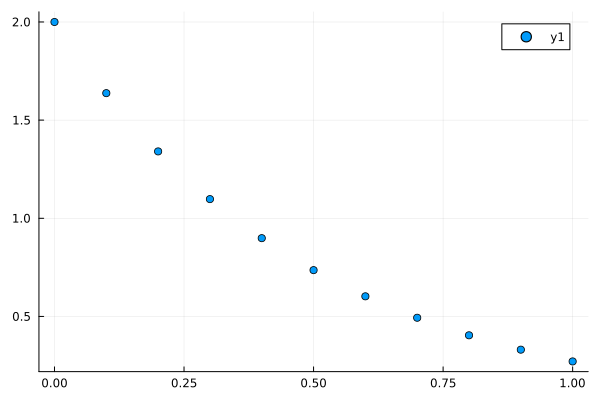

In [8]:
scatter(x,y)

In [29]:
y_exp = y + 0.1*randn(length(y))

11-element Vector{Float64}:
 2.2047734515522985
 1.6113609255481685
 1.2904837297580922
 1.0003801339571485
 0.9914800008202469
 0.8420725792744186
 0.6173519980003039
 0.4568490790518795
 0.43108548128489027
 0.5798161029618183
 0.40196500048598777

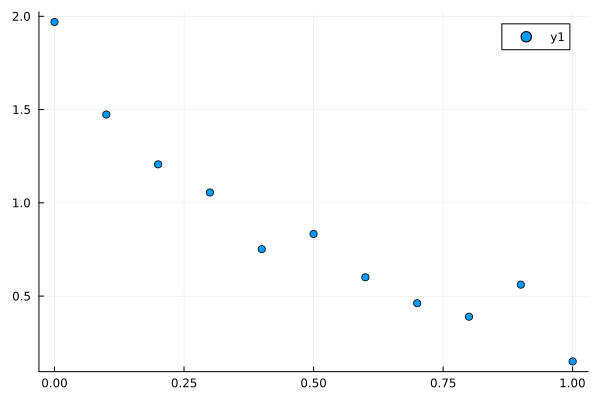

In [10]:
scatter(x,y_exp)

In [11]:
model(x,p) = p[1] .* exp.(-p[2] .* x)

model (generic function with 1 method)

In [12]:
fit = curve_fit(model, x, y_exp, [1.5,1.5])

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([1.8732552184747917, 1.9237265639502341], [-0.09636553197178066, 0.07190493207224469, 0.06873062842979749, -0.0036091177198700475, 0.11598782406589225, -0.11721339899459893, -0.01041422785998758, 0.02543001463380512, 0.012318599899186156, -0.22983969101282692, 0.12373723268884762], [0.9999999999925291 0.0; 0.8249993699007826 -0.1545434374891809; … ; 0.17704454568083267 -0.29848465719667383; 0.1460616386328602 -0.27361072679175746], true, Iter     Function value   Gradient norm 
------   --------------   --------------
, Float64[])

In [13]:
fit.param

2-element Vector{Float64}:
 1.8732552184747917
 1.9237265639502341

In [14]:
cov = estimate_covar(fit)

2×2 Matrix{Float64}:
 0.00746995  0.00898314
 0.00898314  0.0243545

In [15]:
sqrt(estimate_covar(fit))

2×2 Matrix{Float64}:
 0.0769188  0.0394137
 0.0394137  0.151

In [40]:
function res(u, (x,y))
    return u[1] .* exp.( -u[2] .* x) .- y
end

res (generic function with 1 method)

In [41]:
res([1.5,1.5],(x,y_exp))

11-element Vector{Float64}:
 -0.7047734515522985
 -0.32029896091058174
 -0.17925639873551535
 -0.04393790652448848
 -0.16826254667920737
 -0.1335227501628966
 -0.007497508389405216
  0.06805754461485364
  0.020705836583412796
 -0.190955711992981
 -0.06726976026334303

In [42]:
prob = NonlinearLeastSquaresProblem(res, [1.5,2.0], (x,y_exp))

NonlinearLeastSquaresProblem with uType Vector{Float64}. In-place: false
u0: 2-element Vector{Float64}:
 1.5
 2.0

In [43]:
sol = solve(prob, GaussNewton(); maxiters =1000)

retcode: Stalled
u: 2-element Vector{Float64}:
 2.0463518324401155
 1.9169899663437346

In [44]:
function chi2(u,(x,y))
    sum(res(u,(x,y)) .^2 ./ 0.1^2)
end

chi2 (generic function with 1 method)

In [45]:
chi2(sol.u,(x,y_exp))

13.3496704138807

In [46]:
ourchi2(u) = chi2(u,(x,y_exp))

ourchi2 (generic function with 1 method)

In [25]:
ourchi2(sol.u)

11.542979226703359

In [37]:
h = ForwardDiff.hessian(ourchi2,sol.u)

2×2 Matrix{Float64}:
  618.77   -250.154
 -250.154   216.026

In [39]:
sqrt.(inv(2*h))

2×2 Matrix{Float64}:
 0.0389783  0.0419444
 0.0419444  0.0659683

As an experiment to test that this error estimation method is working, we can repeat the procedure many times and compare the standard deviation of the parameter to the estimation from the Hessian.

In [69]:
function lsqfitting(fitfct, (x,y) , sigma, β0)
    res(β,(x,y)) = fitfct(x,β) .- y
    prob = NonlinearLeastSquaresProblem(res, β0, (x,y))
    sol = solve(prob, GaussNewton(); maxiters =1000)
    chi2(β) = sum(abs2, res(β,(x,y)) ./ sigma)
    return sol.u, inv(2*ForwardDiff.hessian(chi2,sol.u))
end

lsqfitting (generic function with 1 method)

In [67]:
f(x,β) = β[1] .* exp.(-β[2] .* x)

f (generic function with 1 method)

In [71]:
bestbeta, covar = lsqfitting(f, (x,y_exp), 0.1, [1.5,1.5])

([2.0463518329458, 1.916989967594574], [0.001519311444122659 0.001759335652709194; 0.001759335652709194 0.0043518196370285495])

In [75]:
sqrt.(covar)

2×2 Matrix{Float64}:
 0.0389783  0.0419444
 0.0419444  0.0659683